In [60]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../../XRaySimulation2")

from XRaySimulation import util
import scipy.signal as sps

import matplotlib
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import LogNorm

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 12

# Explanation
The illumination volume is contains in a region of 
20 um x 40 um x 100 um  (x, y, z)
Therefore, I can create a box with resolution of 1um along each axis
Then, I will calculate if this pixel is illuminated.
Then, I will calculate along the z axis, how many TG periods are in the illumination volume
Then, I'll calculate the mean TG period number

In [61]:
def add_weight_cylinder(start, direction, fwhm_xy, space, attenuation_length_um, surface_point, surface_normal,
                        beam_attenaution=False):
    # Get the distance
    l_pixel = (space - surface_point[np.newaxis, np.newaxis, np.newaxis, :])
    l_pixel = np.dot(l_pixel, surface_normal)
    l_pixel /= np.dot(direction, surface_normal)

    # Get a mask such that we only keep the pixel inside the surface
    sample_mask = (l_pixel >= 0)

    # Get a mask that only consider space inside the cylinder
    displacement = (space - start[np.newaxis, np.newaxis, np.newaxis, :])
    deviation = displacement - np.multiply(np.dot(displacement, direction)[:, :, :, np.newaxis],
                                           direction[np.newaxis, np.newaxis, np.newaxis, :])
    displacement_x = deviation[:, :, :, 0]
    displacement_yz = np.sqrt(deviation[:, :, :, 1] ** 2 + deviation[:, :, :, 2] ** 2)

    # Check if the pixel is within the volume of illumination
    x_ray_mask = (displacement_x ** 2 / fwhm_xy[0] ** 2 + displacement_yz ** 2 / fwhm_xy[1] ** 2 - 1 <= 0)
    total_mask = np.multiply(sample_mask, x_ray_mask)

    # Add the weight according to the attenuation coefficient
    weight = np.zeros_like(displacement_x, dtype=np.float64)
    weight[total_mask] = np.exp(-l_pixel[total_mask] / attenuation_length_um)

    if beam_attenaution:
        print("Get get the weight assuming a Gaussian X-ray profile")
        sigma_x = util.fwhm_to_sigma(fwhm=fwhm_xy[0])
        sigma_y = util.fwhm_to_sigma(fwhm=fwhm_xy[1])

        weight *= np.exp(- displacement_x ** 2 / sigma_x ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_x
        weight *= np.exp(- displacement_yz ** 2 / sigma_y ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_y

    else:
        print("Get get the weight assuming a flat X-ray profile")

    return weight

In [62]:
#kin = np.array([-1398.73758358, -19381.33420562, 45704.44855449])
kin = np.array([-0.11689482, -1.97294018, 4.55617549]) * 1e4
kin_direction = kin / np.linalg.norm(kin)

tilt_angle = np.deg2rad(11.5)
surface_normal = np.array([-np.cos(tilt_angle), 0, np.sin(tilt_angle)])

beam_size_x = 5.  # um
beam_size_y = 10.  # um
coh_length = 10 * util.c  # um

# Get the sigma
beam_sigma_x = util.intensity_fwhm_to_field_sigma(fwhm=beam_size_x)
beam_sigma_y = util.intensity_fwhm_to_field_sigma(fwhm=beam_size_y)
beam_sigma_z = util.intensity_fwhm_to_field_sigma(fwhm=coh_length)

nx = 256
ny = 64
nz = 256 * 2

dx = 11.8 / 100 / 2
dy = 3. / 4
dz = 0.5 / 6

volume = np.zeros((nx, ny, nz, 3))
volume[:, :, :, 0] = np.linspace(-nx * dx / 2, nx * dx / 2, num=nx)[:, np.newaxis, np.newaxis]
volume[:, :, :, 1] = np.linspace(-ny * dy / 2, ny * dy / 2, num=ny)[np.newaxis, :, np.newaxis]
volume[:, :, :, 2] = np.linspace(-nz * dz / 2, nz * dz / 2, num=nz)[np.newaxis, np.newaxis, :]

In [63]:
# Get the total weight
weight_pulse1 = add_weight_cylinder(start=np.array([-0., 0., 0.]),
                                    direction=np.array([np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., 0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse2 = add_weight_cylinder(start=np.array([0., -0., 0.]),
                                    direction=np.array([-np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., 0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse3 = add_weight_cylinder(start=np.array([0., 0., 0.]),
                                    direction=kin_direction,
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., -0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse1[weight_pulse1 < np.max(weight_pulse1) * 1e-6] = 0.
weight_pulse2[weight_pulse2 < np.max(weight_pulse2) * 1e-6] = 0.
weight_pulse3[weight_pulse3 < np.max(weight_pulse3) * 1e-6] = 0.

Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile


In [64]:
# Get the scattering volume
scatter_volume = np.multiply(weight_pulse1 * weight_pulse2, weight_pulse3)
scatter_volume[weight_pulse1 > 100 * weight_pulse2] = 0
scatter_volume[weight_pulse2 > 100 * weight_pulse1] = 0
scatter_volume[weight_pulse3 < 1e-3 * np.max(weight_pulse3)] = 0

# Normalize the scatter_volume 
total_vol = np.sum(np.multiply(weight_pulse3 > np.max(weight_pulse3) / np.exp(3),
                               np.multiply(weight_pulse1 > np.max(weight_pulse1) / np.exp(3),
                                           weight_pulse2 > np.max(weight_pulse2) / np.exp(3)),
                               ))
total_vol *= dx * dy * dz * (1e-6) ** 3
#total_vol = 50 * 30
print(total_vol)

2.1512248124999998e-15


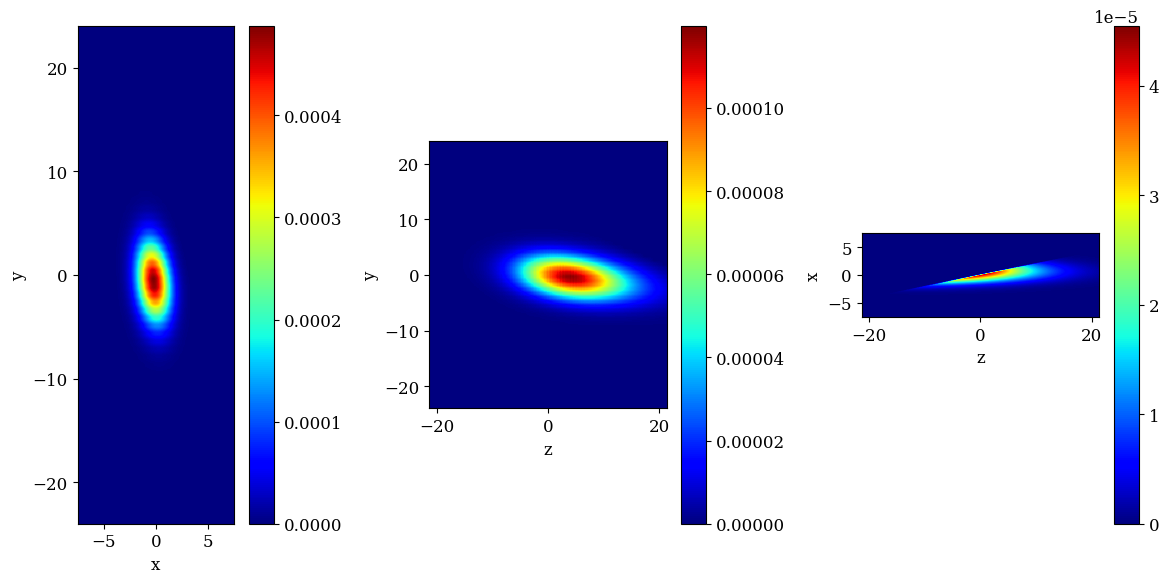

In [65]:
weight_xy = np.sum(scatter_volume, axis=-1)
weight_xz = np.sum(scatter_volume, axis=1)
weight_yz = np.sum(scatter_volume, axis=0)

fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(6)
fig.set_figwidth(12)
im1 = axes[0].imshow(weight_xy.T, extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
fig.colorbar(im1, ax=axes[0])
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

im2 = axes[1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
fig.colorbar(im2, ax=axes[1])
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

im3 = axes[2].imshow(weight_xz, extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet',
                     origin='lower')
fig.colorbar(im3, ax=axes[2])
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

In [66]:
## Get the volume assuming full coherence
volume_fft_raw = np.fft.fftshift(np.fft.fftn(scatter_volume))
volume_fft_raw /= np.max(np.abs(volume_fft_raw))
volume_fft_raw *= total_vol

volume_fft = np.square(np.abs(volume_fft_raw))

kx = np.fft.fftshift(np.fft.fftfreq(n=nx, d=dx)) * np.pi * 2  #/ 1e4
ky = np.fft.fftshift(np.fft.fftfreq(n=ny, d=dy)) * np.pi * 2  #/ 1e4
kz = np.fft.fftshift(np.fft.fftfreq(n=nz, d=dz)) * np.pi * 2  #/ 1e4

proj_yz_perfect = np.sum(volume_fft, axis=0)
proj_xz_perfect = np.sum(volume_fft, axis=1)
proj_xy_perfect = np.sum(volume_fft, axis=2)

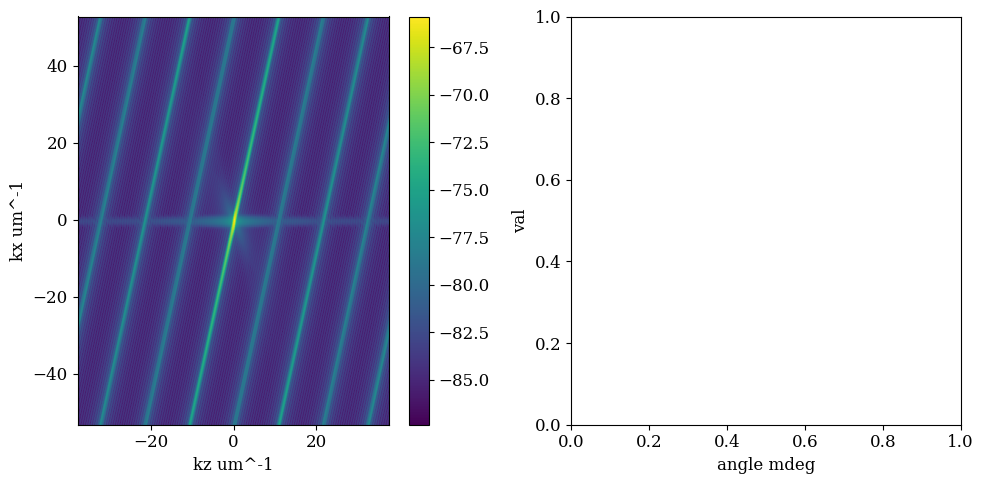

In [67]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

#img1 = axes[0].imshow(np.log(proj_xz), vmax=-16, vmin=-25, extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto')
img1 = axes[0].imshow(np.log(proj_xz_perfect), extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto')
fig.colorbar(img1, ax=axes[0])
axes[0].set_xlabel("kz um^-1")
axes[0].set_ylabel("kx um^-1")

axes[1].set_xlabel("angle mdeg")
axes[1].set_ylabel("val")

plt.tight_layout()
plt.savefig("rocking_fit.png", dpi=300, bbox_inches='tight')
plt.show()

In [68]:
g_vec = np.array([3.11361484, 3.2118638, -0.83751243]) * 1e4  # um^-1
g_dir = g_vec / np.linalg.norm(g_vec)
n_dir1 = np.array([g_vec[1], -g_vec[0], 0.])
n_dir1 /= np.linalg.norm(n_dir1)
n_dir2 = np.cross(g_dir, n_dir1)
n_dir2 /= np.linalg.norm(n_dir2)

# I would like to know what is the difference if there is a 5 mdeg angular difference
max_delta = np.linalg.norm(g_vec) * np.sin(np.deg2rad(3.7e-3))
#max_delta = np.linalg.norm(g_vec) * np.sin(np.deg2rad(2.0e-3))

# Therefore, one needs to consider the Q smearing along the normal direction of the g_vec
# Construct the Q average mask
q_vol = np.zeros((nx, ny, nz, 3))
q_vol[:, :, :, 0] = kx[:, np.newaxis, np.newaxis]
q_vol[:, :, :, 1] = ky[np.newaxis, :, np.newaxis]
q_vol[:, :, :, 2] = kz[np.newaxis, np.newaxis, :]

sigma_g_p = 0.1  # um
sigma_g_n = util.fwhm_to_sigma(2 * max_delta)  # um

q_weight = np.exp(- 0.5 * (np.dot(q_vol, g_dir) ** 2 / sigma_g_p ** 2 +
                           np.dot(q_vol, n_dir1) ** 2 / sigma_g_n ** 2 +
                           np.dot(q_vol, n_dir2) ** 2 / sigma_g_n ** 2))

q_weight /= np.sum(q_weight)
#q_weight = np.sqrt(q_weight)

In [69]:
### Get the total volume
volume_total = sps.fftconvolve(volume_fft, q_weight, mode='same')
#volume_total = np.square(np.abs(volume_total))

### Get the projection
proj_yz = np.sum(volume_total, axis=0)
proj_xz = np.sum(volume_total, axis=1)
proj_xy = np.sum(volume_total, axis=2)

In [70]:
# Get the wave-vectors
angle_num = 1000
angle_list = np.linspace(start=-np.deg2rad(0.05), stop=np.deg2rad(0.05), num=angle_num)

fit_x_m = np.array([6.40342603e-01, 5.06962809e-09]) * 1e4
fit_y_m = np.array([1.99944147e-01, -4.08478486e-07]) * 1e4
fit_z_m = np.array([3.14738445e+00, 2.49180183e-08]) * 1e4

fit_qx_m = angle_list * fit_x_m[0] + fit_x_m[1]
fit_qy_m = angle_list * fit_y_m[0] + fit_y_m[1]
fit_qz_m = angle_list * fit_z_m[0] + fit_z_m[1]

q_list_m = np.zeros((angle_num, 3))
q_list_m[:, 0] = fit_qx_m
q_list_m[:, 1] = fit_qy_m
q_list_m[:, 2] = fit_qz_m

from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator((kx, ky, kz), volume_total, bounds_error=False, fill_value=None)
rock_m_mosaic = interp(q_list_m)

interp = RegularGridInterpolator((kx, ky, kz), volume_fft, bounds_error=False, fill_value=None)
rock_m_ideal = interp(q_list_m)


In [71]:
# Get the wave-vectors
angle_num = 1000
angle_list = np.linspace(start=-np.deg2rad(0.05), stop=np.deg2rad(0.05), num=angle_num)

fit_x_p = np.array([6.41086802e-01, 3.20573762e-09]) * 1e4
fit_y_p = np.array([1.26433034e-01, -4.08953214e-07]) * 1e4
fit_z_p = np.array([3.15104230e+00, 1.57567036e-08]) * 1e4

fit_qx_p = angle_list * fit_x_p[0] + fit_x_p[1]
fit_qy_p = angle_list * fit_y_p[0] + fit_y_p[1]
fit_qz_p = angle_list * fit_z_p[0] + fit_z_p[1]

q_list_p = np.zeros((angle_num, 3))
q_list_p[:, 0] = fit_qx_p
q_list_p[:, 1] = fit_qy_p
q_list_p[:, 2] = fit_qz_p

from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator((kx, ky, kz), volume_total, bounds_error=False, fill_value=None)
rock_p_mosaic = interp(q_list_p)

interp = RegularGridInterpolator((kx, ky, kz), volume_fft, bounds_error=False, fill_value=None)
rock_p_ideal = interp(q_list_p)

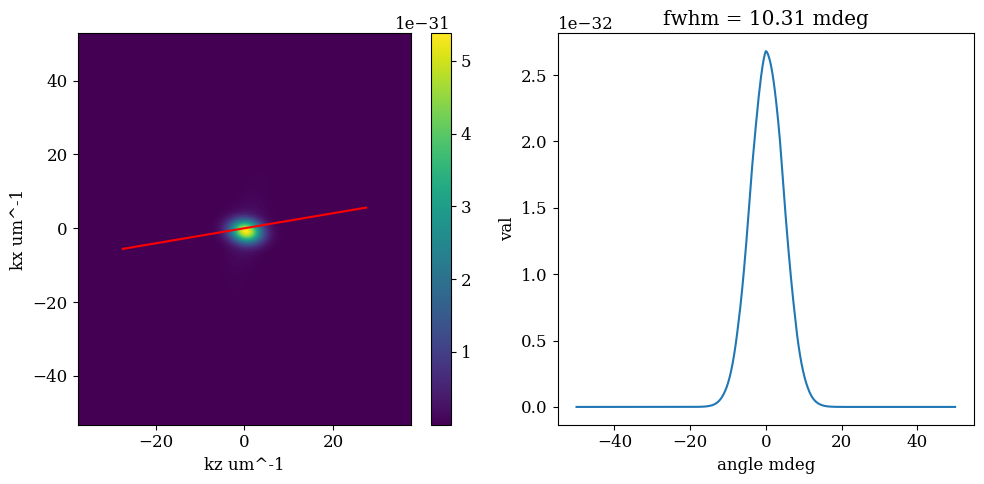

In [72]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

#img1 = axes[0].imshow(np.log(proj_xz), vmax=-16, vmin=-25, extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto')
img1 = axes[0].imshow(np.abs(proj_xz), extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto')
fig.colorbar(img1, ax=axes[0])
axes[0].plot(fit_qz_m, fit_qx_m, c='r')
axes[0].set_xlabel("kz um^-1")
axes[0].set_ylabel("kx um^-1")

axes[1].plot(np.rad2deg(angle_list) * 1e3, rock_m_mosaic)
axes[1].set_xlabel("angle mdeg")
axes[1].set_ylabel("val")
fwhm = util.get_fwhm(coordinate=np.rad2deg(angle_list) * 1e3, curve_values=rock_m_mosaic)
axes[1].set_title("fwhm = {:.2f} mdeg".format(fwhm))

plt.tight_layout()
plt.savefig("rocking_fit.png", dpi=300, bbox_inches='tight')
plt.show()

In [73]:
# Calculate the efficiency
I_in = 25.8 * 0.3 * 0.9 * 6.24150907e12 / 9.8e3  # Use the pump fluence to approximate the probe fluence
print("{:.2e} photon/pulse".format(I_in))
eta_exp = 14 / 9.8 / I_in
print("eta = {:.2e}".format(eta_exp))

#re = 2.818e-15  # m
omega = (75 / 120e3) ** 2  # solid angle
kin_len = np.linalg.norm(kin) * 1e6
kout = kin + g_vec
kout_dir = kout / np.linalg.norm(kout)
po = np.array([0, 1., 0])  # probe X-ray normalization
po -= np.dot(po, kin_direction) * kin_direction
po /= np.linalg.norm(po)
print(po)
polar = np.cross(kout_dir, np.cross(po, kout_dir))
p = np.linalg.norm(polar)

wbar = np.max(volume_total)
print(wbar)
print(wbar * omega)
chi220 = complex(0.10376E-04, -0.60756E-06)

# Calculate the diffraction
I_out = (p ** 2) * omega / (4 * np.pi) ** 2
I_out *= np.abs(chi220 * kin_len ** 2) ** 2
I_out *= wbar

# factor
factor = eta_exp / I_out

print(I_out)
print(factor)

4.44e+09 photon/pulse
eta = 3.22e-10
[-0.01018888  0.91770631  0.39712883]
3.0996500044233505e-32
1.2108007829778714e-38
3.657834764754685e-08
0.008803003537693633


In [83]:
wbar * 1e36

30996.500044233508

In [74]:
total_vol ** 2 / np.max(volume_total)

149.29970116986144

In [75]:
u = np.sqrt(factor) * 2 / np.linalg.norm(g_vec)
print(u * 1e4)
print(u * 1e4 / 3.9)
print(u * 1e4 * (np.pi * 2 / 118))
print(u * 1e4 * (np.pi * 2 / 118) / 11.1e-6)

0.04123190824495672
0.010572284165373518
0.0021954891531499056
197.7918155990906


In [76]:
# Develop an efficient method to cut through the reciprocal space
pixel_center = 120e3 / kout_dir[-1] * kout_dir
det_distance = np.linalg.norm(pixel_center)

# Sample the pixel
pix_nx = 100
x_coor_p = np.linspace(start=-75 / 2., stop=75 / 2., num=pix_nx) + pixel_center[0]

pix_ny = 100
y_coor_p = np.linspace(start=-75 / 2., stop=75 / 2., num=pix_ny) + pixel_center[1]

pixel_sampling = np.zeros((pix_nx, pix_ny, 3))
pixel_sampling[:, :, 0] = x_coor_p[:, np.newaxis]
pixel_sampling[:, :, 1] = y_coor_p[np.newaxis, :]
pixel_sampling[:, :, 2] = 120e3

# calculate the Q for each sampling
pixel_dir = pixel_sampling / np.linalg.norm(pixel_sampling, axis=-1)[:, :, np.newaxis]
Qvec_sample = pixel_dir - kin_direction[np.newaxis, np.newaxis, :]
Qvec_sample *= np.linalg.norm(kin)

q_sample = Qvec_sample - (kout - kin)[np.newaxis, np.newaxis, :]
q_middle = np.mean(q_sample, axis=(0,1))
q_sample -= q_middle[np.newaxis, np.newaxis, :]

# Get the result from the raw volume
interp = RegularGridInterpolator((kx, ky, kz), volume_fft, bounds_error=False,  fill_value=0.0, method='linear')
fitted = interp(q_sample.reshape((pix_nx * pix_ny,3)))
fitted_2d_origin = np.copy(fitted.reshape(pix_nx, pix_ny))


interp = RegularGridInterpolator((kx, ky, kz), volume_total, bounds_error=False,  fill_value=0.0, method='linear')
fitted = interp(q_sample.reshape((pix_nx * pix_ny,3)))
fitted_2d_smear = np.copy(fitted.reshape(pix_nx, pix_ny))


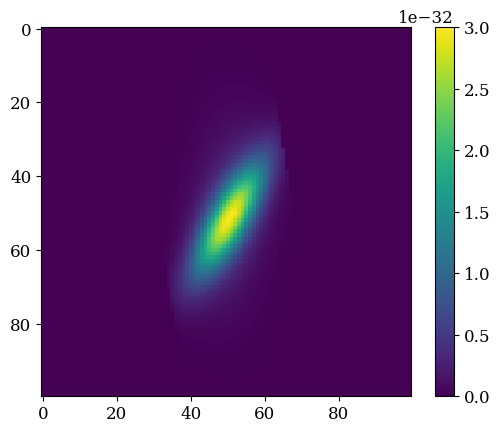

In [77]:
plt.imshow(fitted_2d_smear)
plt.colorbar()
plt.show()

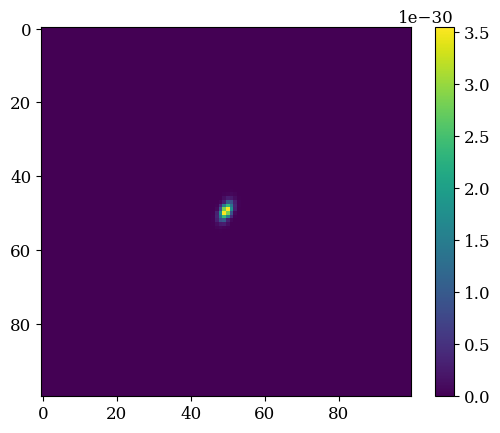

In [78]:
plt.imshow(fitted_2d_origin)
plt.colorbar()
plt.show()

In [79]:
dOmega = (x_coor_p[1] -  x_coor_p[0]) *  (y_coor_p[1] -  y_coor_p[0]) / det_distance ** 2
dOmega *= np.dot(np.array([0., 0., 1.,]), kin_direction)

w_integral = np.sum(fitted_2d_origin) * dOmega
print(w_integral)

w_integral = np.sum(fitted_2d_smear) * dOmega
print(w_integral)

8.026300126664904e-40
1.9860121330286925e-40


In [80]:
print(total_vol * omega)

8.403221923828124e-22


In [81]:
omega

3.90625e-07

In [82]:
dOmega * pix_ny * pix_nx

2.0770035290230152e-07